# Evaluating BGP catchment on Tangled testbed
* Joao Ceron - ceron@botlog.org
* Leandro Bertholdo - leandro.bertholdo@gmail.com

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.style.use('default')

from IPython.display import display
from IPython.display import HTML

import matplotlib
%matplotlib inline
from matplotlib import ticker

import os.path
import re
import numpy as pynum_float

import warnings
warnings.filterwarnings('ignore')

In [2]:
# convert names to airport code
di = {"uk-lnd-anycast02": "LHR", 
      'us-mia-anycast01':"MIA", 
      "au-syd-anycast01":"SYD",
      'fr-par-anycast01': "CDG",
      'jp-hnd-anycast01': "HND",
      'br-poa-anycast01': "POA",
      'us-was-anycast01': "IAD",
      'vultr-nodes' : 'vultr-nodes',
      'ampath-nodes' : 'ampath-nodes',
      'unknown': 'unknown',
      'baseline': 'baseline',
      'all': 'baseline',
     }
di_short = {
      "uk-lnd": "LHR", 
      'us-mia':"MIA", 
      "au-syd":"SYD",
      'fr-par': "CDG",
      'jp-hnd': "HND",
      'br-poa': "POA",
      'us-was': "IAD",
      'vultr-nodes' : 'vultr-nodes',
      'ampath-nodes' : 'ampath-nodes',
      'unknown': 'unknown',
      'baseline': 'baseline',
      'all': 'baseline'
}

In [3]:
# plt.style.available[:5]

---
---
<h1 align="center">Functions</h1>

---
---

In [4]:
def init_fig(width=12,height=5):
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.subplot(111)   
    ax.set_facecolor("#ffffff")
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    fig.tight_layout();
    plt.style.use('default')
    
    return (fig,ax)

In [5]:
def get_and_plot_reference_value(df,site):

    
    df_site = df[df['site']==site].sort_values(by="bgp")
    reference_value = df_site[df_site.bgp=="baseline"].iloc[0,2]

    label = "[{}%] BASELINE".format(int(reference_value))
    # reference value annotation
    ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    # reference value line
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')

    return (reference_value)

In [6]:
!pwd

/Users/bertholdo/GitHub/anygylity-pynb-usenix/usenix_fig6


---
---
<h1 align="center">Read files and build dataframe</h1>

---
---

In [7]:
# get files, parse them and use their names
df_all = pd.DataFrame()

# dir   = "./stats_files/load-2019-12-06-1575649928/*load*.txt"
# dir   = "/Volumes/4T/dataset/2020-01-28-1580170039/load/*load*txt"
# /Volumes/4T/dataset/last/load
dir = "/Volumes/4T/dataset/last/load/*load*.txt"
dir = "/Users/ceron/work/SAND/catchment_manipulation/load-stats/*load*.txt"
# dir = "/Users/joaoceron/work/SAND/catchment_manipulation/load-stats/*load*.txt"
# dir = "/tmp/*load*.txt"
dir = "./stats_files/load-stats/load-new-*"
count = 0
for file in (glob.glob(dir)):
    count +=1
    filename = os.path.basename(file)
#     print ("working on file: {}".format(filename))
    
    
    # read header of stats load file
    fd = open(file, 'r') 
    for line in fd.readlines():
        if ("date" in line):
            id = line.split(",")[1].rstrip('\n')
        elif ("bgp_policy" in line):
            bgp = line.split(",")[1].rstrip('\n')
        elif ("active_nodes" in line):
            active_nodes = line.split(",")[1].rstrip('\n')
    ###
    ### BUILD Dataframe using load files 
    ###
    
    #1 - process the baseline stats file - regular prefixes announcemnt
    if (bool(re.search('baseline', filename))):     
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)       
        df['bgp_policy'] = "baseline"
        df['time'] = id
        df['bgp_policy_location'] = "all"
        df['num_prepend'] = 0
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 
        
    # 2 - process prepend files
    elif re.search(r'(?=.*\bprepend\b.*)(?!.*\bvultr\b.*)(?!.*\bcommunity\b.*)(?!.*\bampath\b.*).*$', filename, re.M):

        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        num_prepend = int(re.search('.*-(\d)x-.*anycast\d{2}', bgp).group(1))

        if (bool(re.search('negative', bgp))):
            num_prepend = num_prepend*-1

        df['bgp_policy'] = "prepend"
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = num_prepend
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 
            
    # 3 - process communities load files
    elif re.search(r'(?=.*\bcommunit\b.*)(?!.*\bvultr\b.*)(?!.*\bampath\b.*).*$', filename, re.M):
            
        print ("community {}".format(filename))
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        community = (re.search('community-([0-9:,]+)-\w\w-.*cast\d\d',bgp).group(1))
        df['bgp_policy'] = "community"
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = 0
        df['community'] = community
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 

    # 4 - node withdraw
    elif (bool(re.search('-withdraw', filename))): 
        df = pd.read_csv(file,names=['site', 'count','percent'],skiprows=4)  
        site = re.search('.*(\w{2}-\w+)-anycast\d{2}', bgp).group(1)
        df['bgp_policy'] = bgp
        df['time'] = id
        df['bgp_policy_location'] = site
        df['num_prepend'] = 0
        df['community'] = "None"
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        df_all = pd.concat([df, df_all],sort=False) 

    # vultr prepending
    elif re.search(r'(?=.*\bprepend\b.*)(?=.*\bvultr\b.*).*$', filename, re.M):
        df = pd.read_csv(file,names=['site', 'count','percent'], skiprows=4)  
        df['time'] = id
        df['bgp_policy_location'] = "vultr-nodes"
        df['num_prepend'] = int(re.search('.*-(\d)x-.*node.*', bgp).group(1))
        df['community'] = "None"
        bgp = "-".join(str(x) for x in bgp.split("-")[0:2]).replace('-regular_positive','')
        df['bgp_policy'] = bgp
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3)
        found = df[df['count']==500034]['count']
        if (int(found.count())>0):
            print ("vultr prepending")
        df_all = pd.concat([df, df_all],sort=False) 

        
    # ampath prepending
    elif re.search(r'(?=.*\bprepend\b.*)(?=.*\bampath\b.*).*$', filename, re.M): 
        df = pd.read_csv(file,names=['site', 'count','percent'], skiprows=4)
        df['time'] = id
        df['bgp_policy_location'] = "ampath-nodes"
        df['num_prepend'] = int(re.search('.*-(\d)x-.*node.*', bgp).group(1))
        df['community'] = "None"
        bgp = "-".join(str(x) for x in bgp.split("-")[0:2]).replace('-regular_positive','')
        df['bgp_policy'] = bgp
        df['percent'] = (df['count']/df['count'].sum()).mul(100).round(3) 
        df_all = pd.concat([df, df_all],sort=False) 

    
print ("Files loaded: {}".format(count))
df=df_all
df['site']  =  df['site'].map(di)
df['bgp_policy_location']  =  df['bgp_policy_location'].map(di_short)


# df.to_csv("catchment-load-communities-prepend.csv", sep=';')

# remove prepend vs community prepend experiment from df (keep on df_all)
df = df[~df['bgp_policy_location'].str.contains("nodes")]
df_all.head()

Files loaded: 101


,site,count,percent,time,bgp_policy_location,num_prepend,community,bgp_policy
0,LHR,958927,15.580,2020-02-07-09:22:17,ampath-nodes,1,None,prepend
1,SYD,775705,12.603,2020-02-07-09:22:17,ampath-nodes,1,None,prepend
2,POA,726593,11.805,2020-02-07-09:22:17,ampath-nodes,1,None,prepend
3,IAD,514483,8.359,2020-02-07-09:22:17,ampath-nodes,1,None,prepend
4,CDG,281950,4.581,2020-02-07-09:22:17,ampath-nodes,1,None,prepend


---
---
<h1 align="center">Baseline Catchment</h1>

---
---

,count,percent,time,bgp_policy_location,num_prepend,community,bgp_policy
site,,,,,,,
LHR,796172,12.936,2020-01-31-23:10:04,baseline,0,None,baseline
POA,714439,11.608,2020-01-31-23:10:04,baseline,0,None,baseline
SYD,584351,9.494,2020-01-31-23:10:04,baseline,0,None,baseline
MIA,543614,8.832,2020-01-31-23:10:04,baseline,0,None,baseline
IAD,520290,8.453,2020-01-31-23:10:04,baseline,0,None,baseline
CDG,245800,3.994,2020-01-31-23:10:04,baseline,0,None,baseline
HND,1,0.000,2020-01-31-23:10:04,baseline,0,None,baseline
unknown,2750121,44.683,2020-01-31-23:10:04,baseline,0,None,baseline


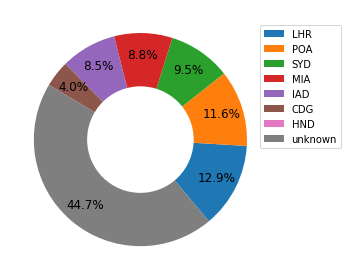

In [8]:

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot2grid((1,1), (0,0))

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (val==0):
            return 
        return '{p:.1f}%'.format(p=pct,v=val)
    return my_autopct

result = df[df['bgp_policy'].str.contains("baseline")].copy()
result.set_index('site',inplace=True)
result.plot(ax=ax, 
            y='percent',
            autopct=make_autopct(result['count']),
            startangle=-50, 
            pctdistance=0.8, 
            kind="pie",
            fontsize=12,
            labels=None)

labels=result.index
ax.legend(labels, loc='upper center', bbox_to_anchor=(1.1,0.95))

centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle);
ax.set_ylabel('')
fig.tight_layout()
fig.show()
result

---
---
<h1 align="center">Catchment investigation using prepends</h1>

---
---

# OVERALL

## A - positive prepend

In [9]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']=0]
# data[data.bgp_policy_location=="HND"]580228
# data[data['count'==580228]]
data[data['count']==500034]

,site,count,percent,time,bgp_policy_location,num_prepend,community,bgp_policy
1,IAD,500034,8.124,2020-01-31-23:10:04,POA,-2,None,prepend


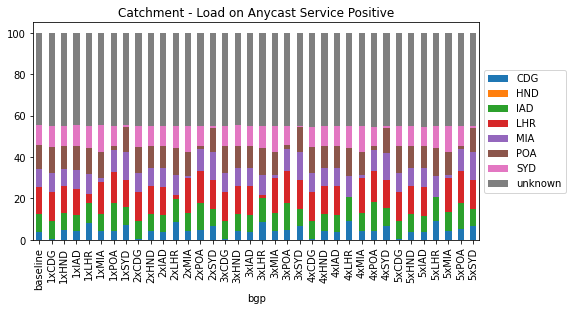

In [10]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service Positive".format(site));  

## B - negative prepend

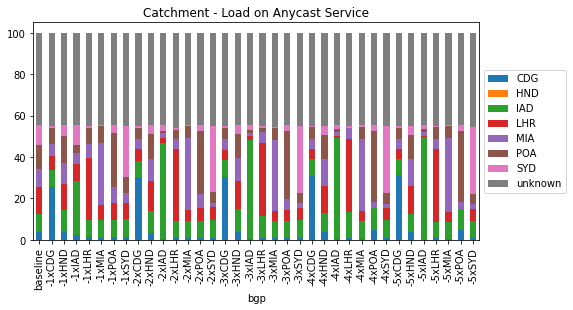

In [11]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data = data[data['num_prepend']<=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['percent'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
fig = plt.figure(figsize=(8, 4))
ax = plt.subplot2grid((1,1), (0,0))
data.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
ax.set_title("Catchment - Load on Anycast Service".format(site));  

## C. Impact of path prepending in catchment 

245800.0


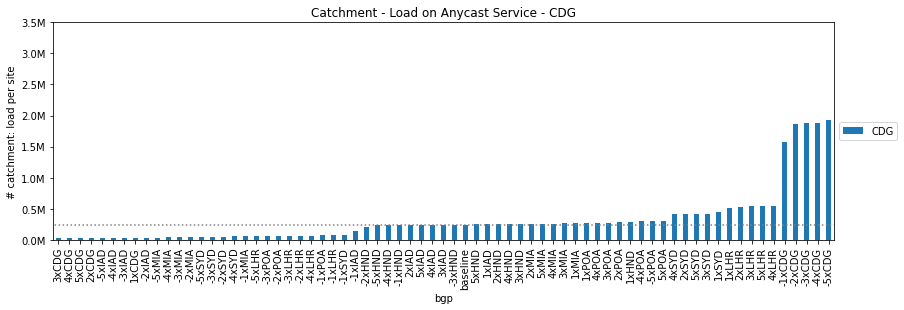

1.0


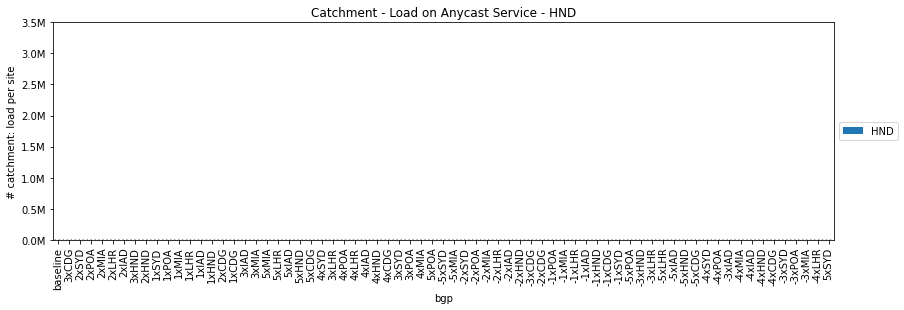

520290.0


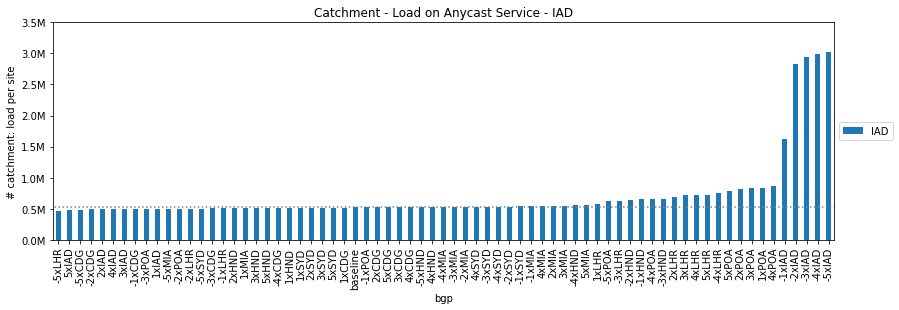

796172.0


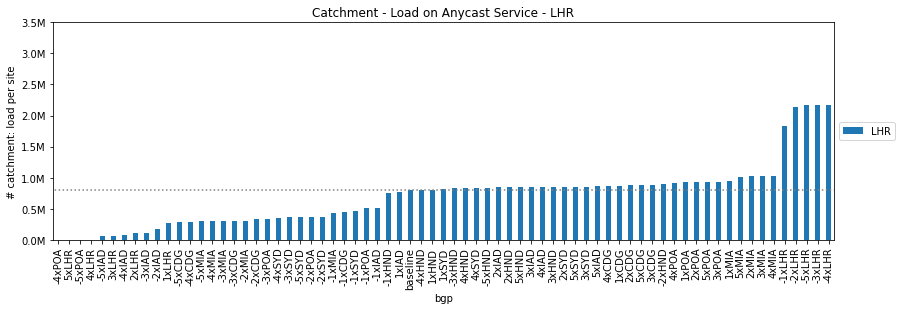

543614.0


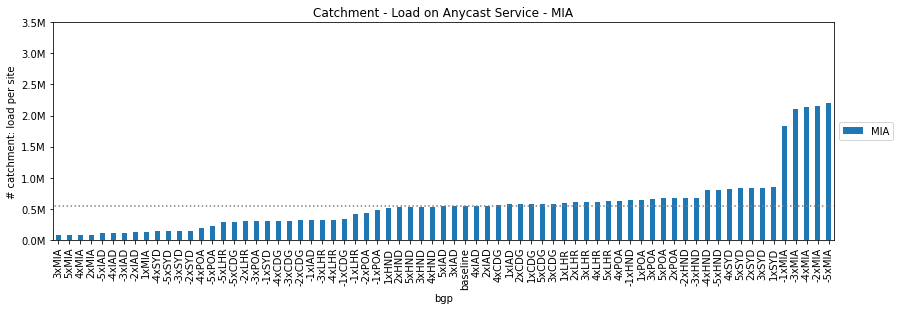

714439.0


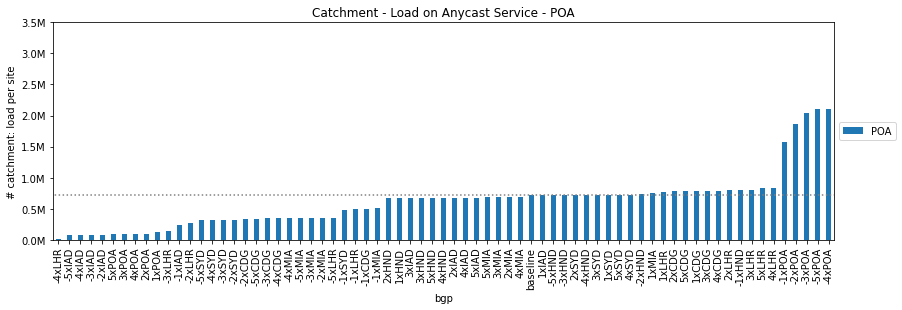

584351.0


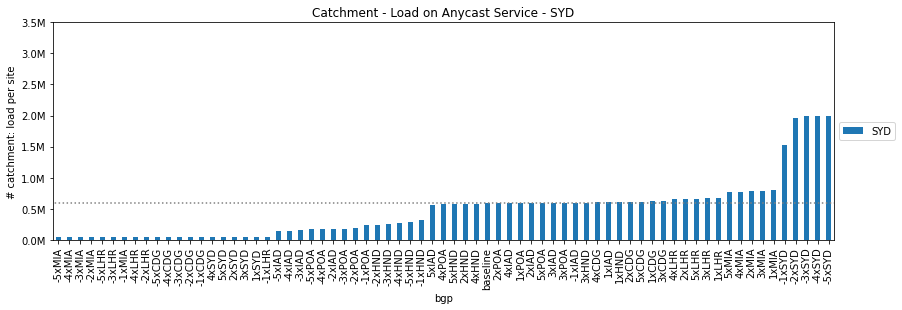

2750121.0


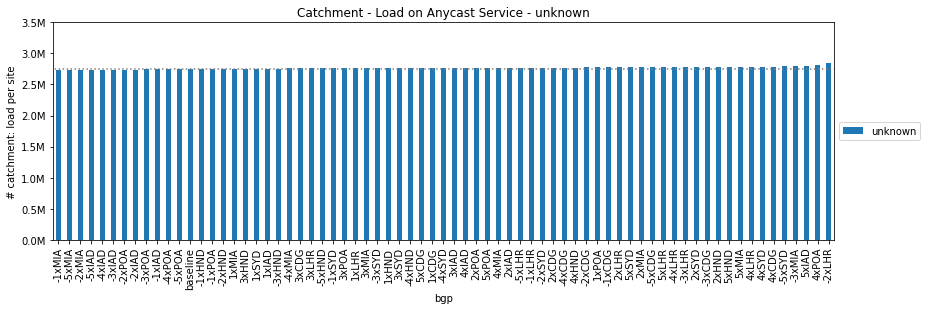

In [12]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
columns_name = data.columns.get_level_values(0)

for col in columns_name:
    
    fig = plt.figure(figsize=(14, 4))
    ax = plt.subplot2grid((1,1), (0,0))
    
    data_site = data.loc[:,col].sort_values()
#     data_site = data.loc[:,col] 

    data_site.plot(ax=ax,
          kind='bar', 
          stacked=True,
         );
    df_site = data_site.reset_index()
    reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
    print (reference_value)

   # label = "[{}%] BASELINE".format(int(reference_value))
   # ax.annotate(label,xy=(25, reference_value), ha='right',color='black',va='bottom')
    ax.axhline(y=reference_value, xmin=-1, xmax=1.0, color='grey', linestyle='dotted')
    
    ax.set_ylim(ymax=3500000, ymin=0);
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
#     ax.set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

    ax.set_title("Catchment - Load on Anycast Service - {}".format(col));  
    ax.set_ylabel('# catchment: load per site');
    title = "<h2 style=\"color:#069\" >How prepending affects the load of site: {} </h2>".format(col.upper())
    display(HTML(title))
    plt.show()
    

## same values, another visualization

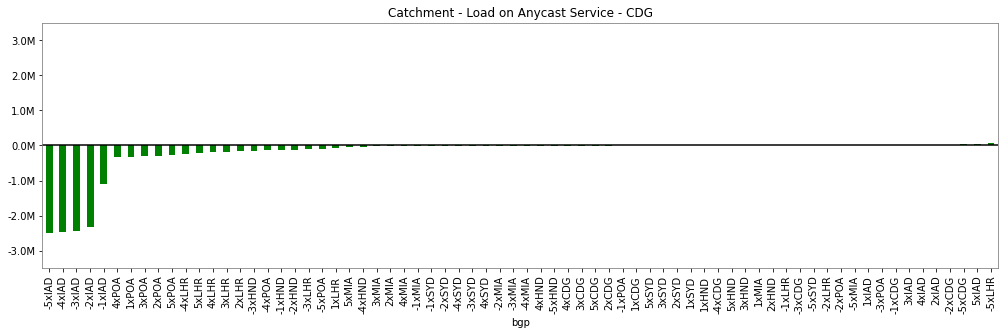

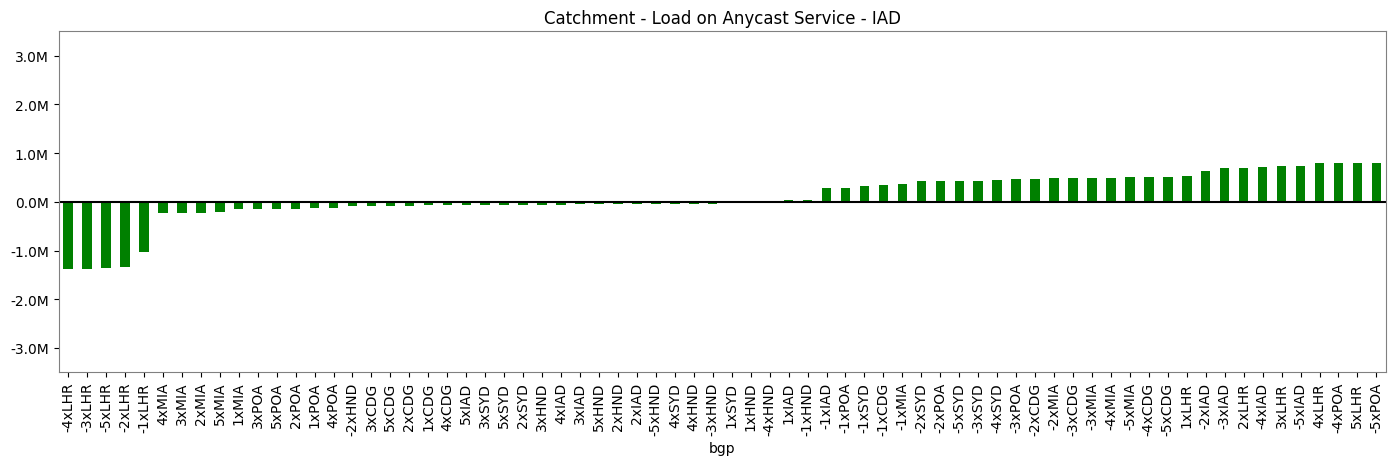

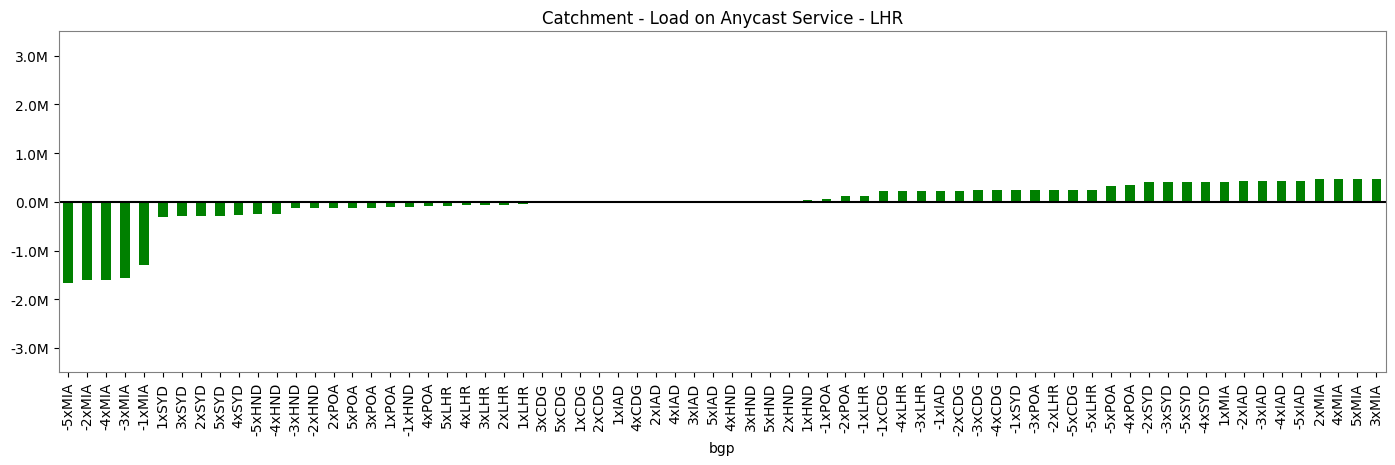

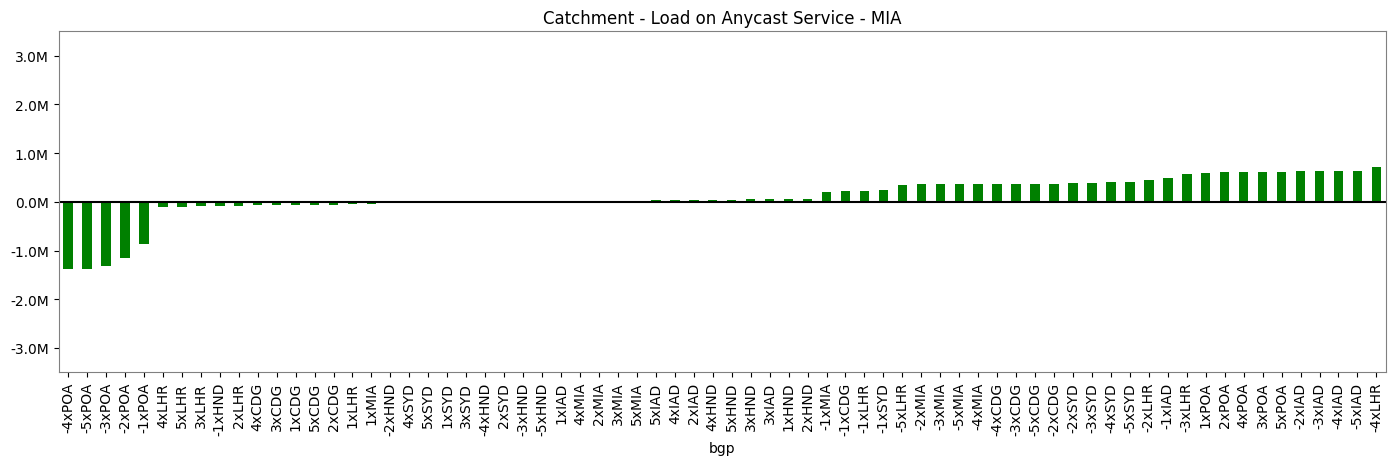

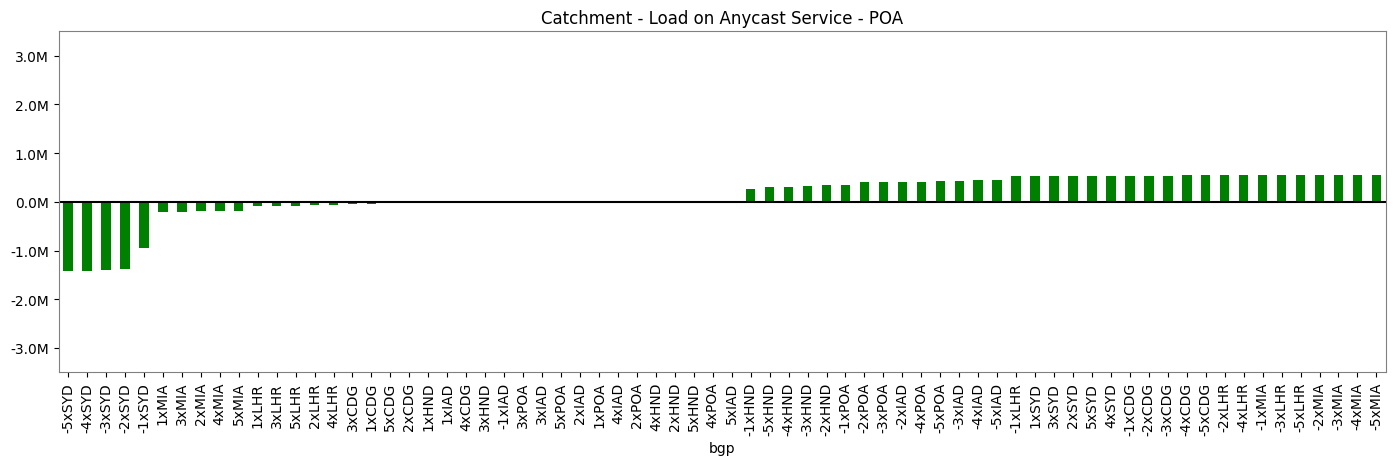

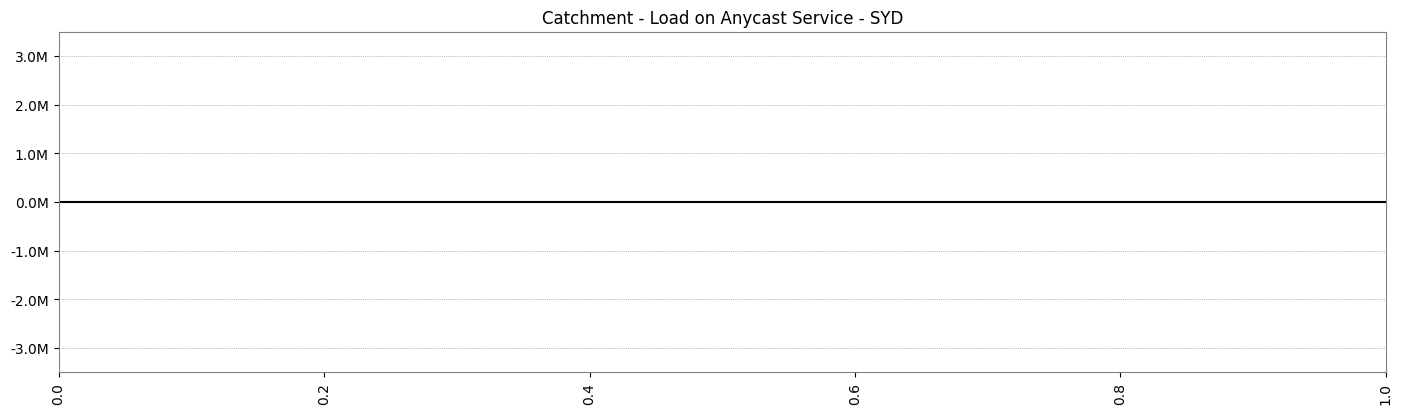

In [13]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

data.drop('HND',1,inplace=True)
data.drop('unknown',1,inplace=True)    
columns_name = data.columns.get_level_values(0)

for site in columns_name:
    baseline  = data.iloc[[0]].values[0]
    data_diff = data.iloc[1:].apply(lambda x: (baseline-x), axis=1)  
    data_diff[site].sort_values().plot(kind="bar",ax=ax, stacked=False,color="green")

    (fig,ax) = init_fig(14,4)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels,rotation=90);
    ax.set_ylim(ymax=3500000,ymin=-3500000);
    ax.axhline(y=0, xmin=-1, xmax=1.0, color="black")
    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    ax.set_title("Catchment - Load on Anycast Service - {}".format(site)); 
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]); 

## Leandro's Idea
## Anycast Service maximum and minimum

In [14]:
regex_prepend_site = "prepend|baseline|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()
# data = data[data['num_prepend']>=0]
data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")

# fix column names
data.columns=data.columns.get_level_values(0)
data.columns = data.columns.to_list()
df_prepend = data
df_prepend.head()

,CDG,HND,IAD,LHR,MIA,POA,SYD,unknown
bgp,,,,,,,,
baseline,245800.0,1.0,520290.0,796172.0,543614.0,714439.0,584351.0,2750121.0
-1xCDG,1566418.0,1.0,495453.0,443092.0,329853.0,497518.0,47549.0,2774904.0
-1xHND,235341.0,1.0,652208.0,759538.0,640007.0,801860.0,315584.0,2750249.0
-1xIAD,141394.0,1.0,1614949.0,507450.0,317966.0,231234.0,595158.0,2746636.0
-1xLHR,81971.0,1.0,508383.0,1829601.0,419133.0,492276.0,50899.0,2772524.0


In [15]:
data = pd.DataFrame()
regex_prepend_site = "prepend|baseline|with|all"
data = df[df['bgp_policy'].str.contains(regex_prepend_site)].copy()

data['num_prepend'] = data['num_prepend'].astype(str)
data['bgp'] = data['num_prepend']+"x"+ data['bgp_policy_location']
data.loc[data['bgp'].str.contains('0xbaseline'), 'bgp'] = 'baseline'
data = data.groupby(['site','bgp'])['count'].sum().unstack().T.fillna(0)
data.columns = data.columns.get_level_values(0).tolist()
data = pd.concat([data.tail(1),data])
data = data.drop_duplicates(keep="first")
data.to_csv("prepend+withdraw-dataframe.csv",sep=";")

### Extract MAX/MIN/BASELINE from prepend dataframe for each node

In [16]:
# get max value per line
max_policy_label = data.T.idxmax(axis=1)
max_policy_value=data.T.max(axis=1)

# get min value per line
min_policy_label = data.T.idxmin(axis=1)
min_policy_value=data.T.min(axis=1)

# get baseline values
df_baseline = data.iloc[0,:]

# build dataframe
df_result = pd.concat([max_policy_value,
                       min_policy_value,
                       df_baseline,max_policy_label,
                       min_policy_label],
                       axis=1
                     ) 
df_result.columns=['max','min','baseline','max_label','min_label']
# remove nodes
df_result = df_result[df_result.index!="unknown"]
df_result = df_result[df_result.index!="HND"]

,max,min,baseline,max_label,min_label
CDG,1928542.0,0.0,245800.0,-5xCDG,0xCDG
IAD,3015529.0,0.0,520290.0,-5xIAD,0xIAD
LHR,2175304.0,0.0,796172.0,-4xLHR,-4xPOA
MIA,2203564.0,0.0,543614.0,-5xMIA,0xMIA
POA,2104090.0,0.0,714439.0,-4xPOA,0xPOA
SYD,1997357.0,0.0,584351.0,-5xSYD,0xSYD


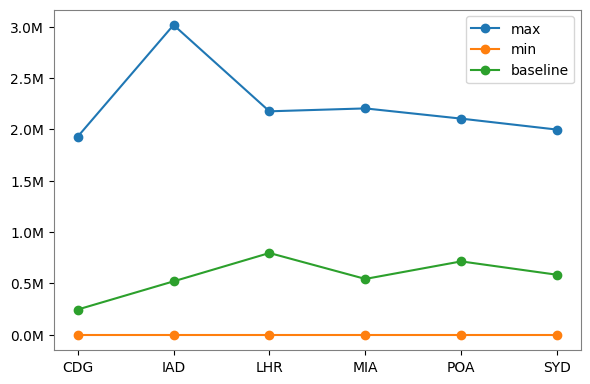

In [17]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)   
ax = plt.subplot2grid((1,1), (0,0))

ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
fig.tight_layout();
plt.style.use('default')

df_result[['max','min','baseline']].plot(marker='o',ax=ax)
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])

df_result

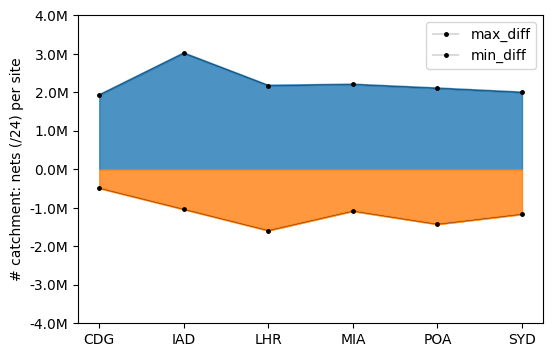

In [18]:
df_result['max_diff'] = (df_result['max'] - df_result['baseline'])   + df_result['baseline']
df_result['min_diff'] = (df_result['min'] - df_result['baseline'] ) - df_result['baseline']
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot2grid((1,1), (0,0))
df_result[['max_diff','min_diff']].plot(kind='area',ax=ax,alpha=0.8)
df_result[['min_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
df_result[['max_diff']].plot(kind='line',marker=".",
                             markersize=5,
                             color="black",
                              linewidth=0.2,
                             ax=ax,legend=[])
ax.set_ylim(ymax=4000000, ymin=-4000000);
ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()]);
ax.set_ylabel('# catchment: nets (/24) per site');
# ax2 = ax.twinx()
# ax.get_yticks().tolist()


In [19]:
# data_site.iloc[0:1][0]
# data_site[data_site.iloc[0]=="baseline"]

df_site = data_site.reset_index()
reference_value = data_site.reset_index()[df_site.bgp=="baseline"].iloc[0,1]
reference_value

2750121.0

---
---
<h1 align="center">Effect of prepeding on each site</h1>

---
---

In [20]:
available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

CDG


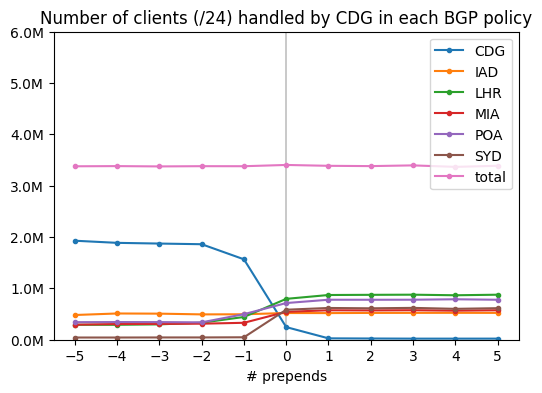

IAD


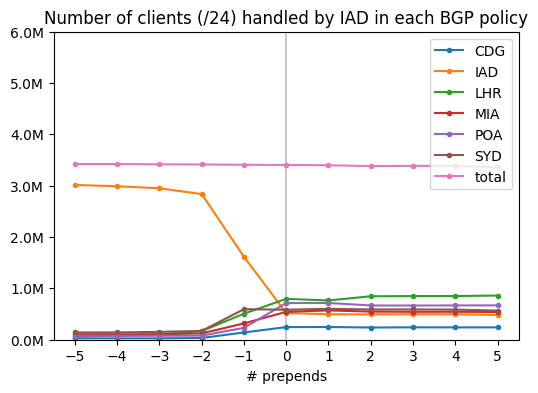

LHR


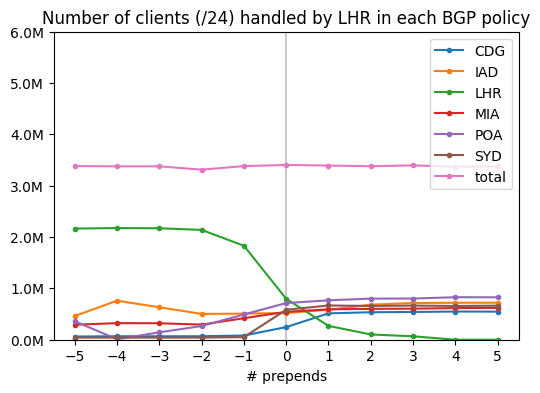

MIA


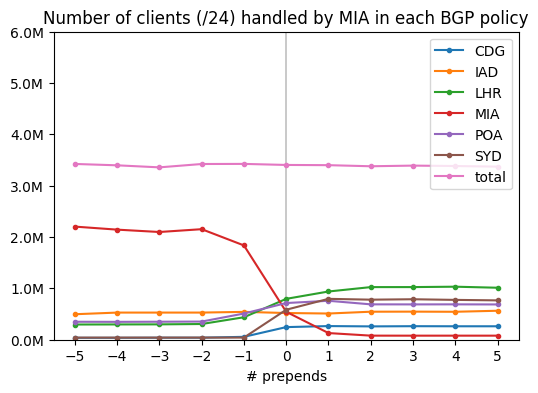

POA


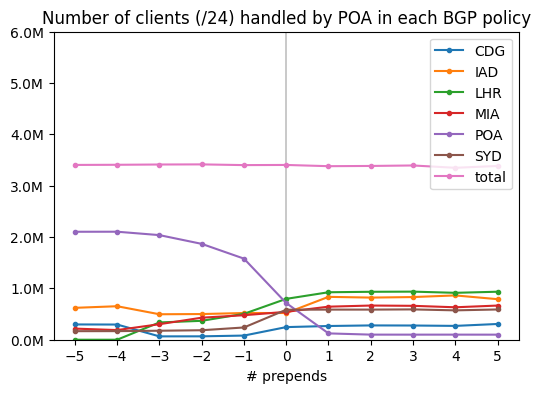

SYD


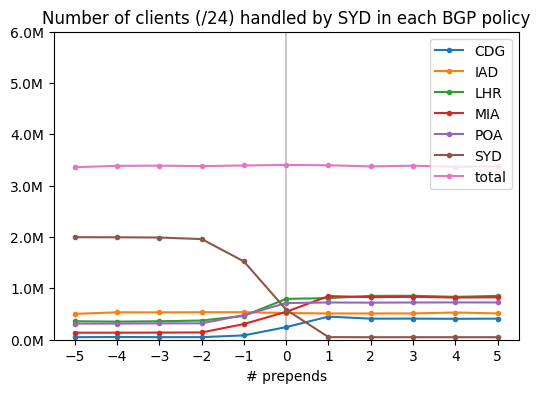

In [21]:
for prepend_site in available_nodes:

    data = df_prepend.copy()
    print (prepend_site)
    # prepare dataframe
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)]
    data.drop('HND',1,inplace=True)
    data.drop('unknown',1,inplace=True)
    data.reset_index(inplace=True)
    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    data['total'] = data.sum(axis=1)
    
    # prepare graph
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot(111)   
    ax.set_ylim(ymax=6000000);
    ax.axvline(x=0, color='black',linewidth=0.3)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    data.plot(kind="line",ax=ax, marker=".")
    ax.set_xlabel('# prepends');
    ax.set_title("Number of clients (/24) handled by {} in each BGP policy".format(prepend_site));   
    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    plt.show()

---
---
<h1 align="center">Effect of self-prepending on all the sites</h1>

---
---

In [22]:
available_nodes = df_prepend.columns.to_list()
available_nodes.remove('unknown')
available_nodes.remove('HND')
available_nodes

['CDG', 'IAD', 'LHR', 'MIA', 'POA', 'SYD']

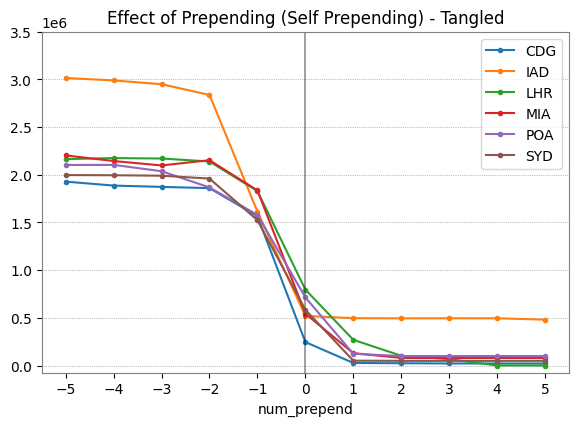

In [23]:
(fig,ax) = init_fig(6,4)
ax.set_title("Effect of Prepending (Self Prepending) - Tangled")

for prepend_site in available_nodes:
# for prepend_site in  ['CDG']: 

    # prepare dataset
    data = df_prepend.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    
    # plot graph
    data.plot(kind="line",
              marker=".",
              ax= ax)
    
    ax.set_ylim(ymax=3500000);
    ax.axvline(x=0, color='black',linewidth=0.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))        
    
    #ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    #ax.set_ylabel('# number of clients (/24) - hitlist replies');
    #ax.set_xlabel('# prepends');

#     filename = "/Users/joaoceron/work/WORKING/ANT_GIT/PAPERS/ddos_anycast/FIG/TANGLED/self_prepending_tangled.pdf"
#    ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
#     fig.savefig(filename, bbox_inches='tight', dpi=1200)

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)

In [24]:
data = df_prepend.copy()
data.head()
data.drop('unknown',1,inplace=True)
data['total'] = data.sum(axis=1)
data
data_percent = pd.DataFrame()
data_percent['bgp'] = data.index
data = data.reset_index()
data_percent
data.head()

for node in data.columns[1:8]:
    node_pct = "{}_pct".format(node)
    data_percent[node] = (data[node]/data['total']).mul(100).round(3)
data_percent.head(1)
data_percent.set_index('bgp',inplace=True)

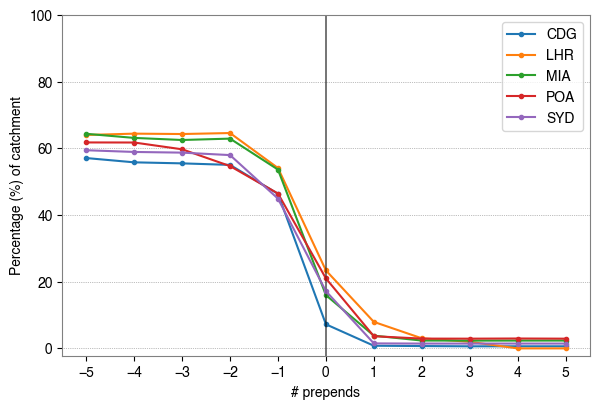

In [25]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

(fig,ax) = init_fig(6,4)

plt.rcParams.update({'font.sans-serif':'Helvetica'})
#ax.set_title("Effect of Prepending (Self Prepending) - Tangled")
available_nodes = ['CDG', 'LHR', 'MIA', 'POA', 'SYD']
# available_nodes = ['CDG', 'LHR']
for prepend_site in available_nodes:

    # prepare dataset
    data = data_percent.copy()
    regex_prepend_site = prepend_site+"|baseline|all"
    data = data[data.index.str.contains(regex_prepend_site)][prepend_site]
    self_prepending = data
    data = data.reset_index()
    

    data[['num_prepend','loc_prepend']] = data.bgp.str.split("x",expand=True)
    data.loc[data['num_prepend'] == "baseline", ['num_prepend']] =  0
    data.num_prepend = data.num_prepend.astype(int)
    data = data.sort_values(by='num_prepend', ascending=True)
    data = data.set_index('num_prepend')
    data.drop('loc_prepend',1,inplace=True)
    data.drop('bgp',1,inplace=True)
    
    
    # plot graph
    data.plot(kind="line",
              marker=".",
              ax= ax)
    
    ax.axvline(x=0, color='black',linewidth=0.1)
    ax.xaxis.set_major_locator(plt.MaxNLocator(11))
    ax.set_ylabel('Percentage (%) of catchment');
    ax.set_xlabel('# prepends');
    ax.set_ylim(ymax=100);
    #plt.gca().set_yticklabels(['{:.0f}%'.format(x*1) for x in plt.gca().get_yticks()]);
    ax.axvline(x=0, color='black',linewidth=0.1)

    ax.yaxis.grid(color='grey', linestyle='dotted', linewidth=0.5)
    
    #filename = "/Users/bertholdo/PAPERS/ddos_anycast/USENIX/FIG/TANGLED/self_prepending_tangled_v2.pdf"
    #ax.set_yticklabels(['{:,}M'.format((x/1000000)) for x in ax.get_yticks().tolist()])
    #fig.savefig(filename, bbox_inches='tight', dpi=1200)



---
---
<h1 align="center">B-Root testbed</h1>

---
---

In [26]:
# available_nodes = df.loc_prepend.unique().tolist().reverse()[1:]
# available_nodes